<h1>Environment</h1>

Verify that we have the correct version of astropy:

In [1]:
import astropy
print(astropy.__version__)

1.0.2


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Data input</h1>

Begin by importing the helper functions in the 'proto' package:

In [3]:
import fit_functions

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be included in fit: simple 2-column ASCII file

In [4]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"

The read_file function reads the spectrum file and an optional regions file. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Mask is a float numpy array with 1's for good data points and 0's for ignored data points. This can be used directly in the fitting engine as a weight array.

In [5]:
spectrum, mask = fit_functions.read_file(datafile, regions=regionsfile)

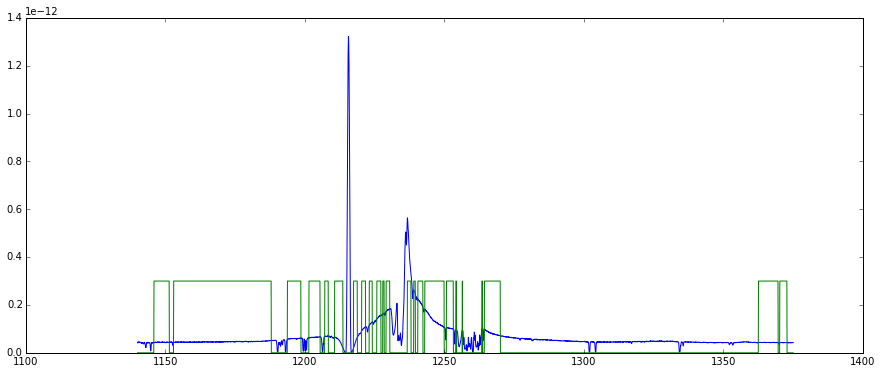

In [6]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, mask*3.E-13, 'g')

<h1>First guess model</h1>

The model is imported directly:

In [7]:
import n5548_models as models

The .py module defined above builds one or more instances of a special type of function defined in the astropy.modeling.models package, called a "compound model". 

A compound model is just a combination of astropy.modeling.models functions, using as combination operators such things as addition, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

An actual, importable model definition will look like this:

```python
from custom_models import gaussian, powerlaw, ccmext

model1 = \
    powerlaw(name = 'powerlaw1',
             amp =   6.586200E-14,
             x_0 =   1000.0,
             alpha = 0.4819233,
             bounds = {'amp':   (0., 1.00E-11),
                       'x_0':   (0., 1.00E-11),
                       'alpha': (-5., 5.)},
             fixed = {'x_0': True}
             ) \
+ \
    gaussian(name = 'C III 1176',
             norm = 2.000000E-14,
             mean = 1195.006,
             fwhm = 861.4926,
             bounds = {'norm': (0., 1.00E-10),
                       'mean': (1000., 2000.),
                       'fwhm': (1000., 2000.),
                       'skew': (1., 1.)},
             fixed = {'norm': True,
                      'mean': True,
                      'fwhm': True,
                      'skew': True},
             ) \
```             


For this exercise, we pick the model named 'model1':

In [8]:
compound_model = models.model1

The module uses some special function types, defined by overriding the standard functions in asytropy.modeling.models in module custom_models. 

This overriding is necessary because the spectral components in specfit do not conform with the standards defined in astropy.modeling.models. For example, a Gaussian in specfit is defined by an amplitude, a central wavelength, a FWHM in km/s, and a skweness parameter. In astropy.modeling.models a Gaussian is defined by an amplitude, a central wavelength, and a width in units consistent with the units of the central wavelength. And no skewness parameter. These incompatibilities are addressed by the sub-classes defined in the fit_functions module. 

In [9]:
print(compound_model)

Model: CompoundModel20
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_0 x_0_0   alpha_0   ebmv_1 ... mean_21  fwhm_21   skew_21 
    ----------- ------ --------- ------- ... -------- -------- ---------
     6.5862e-14 1000.0 0.4819233 0.01713 ... 1262.044 3683.102 0.1849483


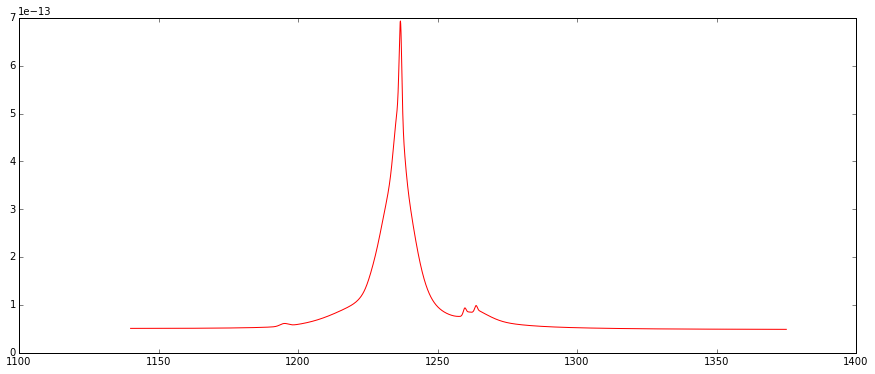

In [10]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

The actual fitting then is a very simple operation. First, we instantiate a fitter engine:

In [11]:
import astropy.modeling.fitting as fitting

In [12]:
fitter = fitting.LevMarLSQFitter()

In this example, we have access to the errors for the data points, so we can use their inverse as weights for the fit:

In [13]:
import numpy as np
w = mask.copy()
w /= spectrum.e.data
max_w = np.max(w)
w /= max_w

And the fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed. Let's do some timing as well:

In [14]:
import time
start_time = time.time()

fit_result = fitter(compound_model, spectrum.x.data, spectrum.y.data, weights=w, acc=1.E-30, maxiter=6000)

end_time = time.time()

In [15]:
print(fitter.fit_info['message'])

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


The result is another instance of a compound model, with the fitted values set into the  parameter values:

In [16]:
print(fit_result)

Model: CompoundModel20
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
       amplitude_0    x_0_0     alpha_0    ...  mean_21   fwhm_21   skew_21 
    ----------------- ------ ------------- ... ---------- -------- ---------
    1.35102678977e-13 1000.0 1.55048402411 ... 1262.04447 3683.102 0.1849483


Lets print some derived results:

Chi-sq computation: number of free parameters is the total number of parameters, minus the number of fixed and tied parameters:

In [17]:
if 'fixed' in fit_result.parameter_constraints:
    fix = np.asarray(fit_result.fixed.values())
    n_fixed_parameters = np.sum(np.where(fix, 1, 0))
else:
    n_fixed_parameters = 0

if 'tied' in fit_result.parameter_constraints:
    tie = np.asarray(fit_result.tied.values())
    n_tied_parameters = np.sum(np.where(tie, 1, 0))
else:
    n_tied_parameters = 0

n_free_par = len(fit_result.parameters) - n_fixed_parameters - n_tied_parameters

chisq_in = fit_functions.chisq(spectrum.x.data, spectrum.y.data, spectrum.e.data, mask, compound_model, n_free_par)
chisq_out = fit_functions.chisq(spectrum.x.data, spectrum.y.data, spectrum.e.data, mask, fit_result, n_free_par)
print("chisq from input model:  %f" % chisq_in)
print("chisq from output model: %f" % chisq_out)
print("Total data points: %d" % len(spectrum.x.data))
print("Data points in wavelength ranges: %d" % np.sum(mask))
print("Number of free parameters: %d" % n_free_par)
print("Number of iterations: %d" % fitter.fit_info['nfev'])
print ("Fit engine took %d elapsed seconds." % (end_time - start_time))

chisq from input model:  19.224055
chisq from output model: 10.229848
Total data points: 6058
Data points in wavelength ranges: 2318
Number of free parameters: 11
Number of iterations: 581
Fit engine took 24 elapsed seconds.


Errors associated with each free parameter:

In [18]:
cov = fitter.fit_info['param_cov']

# extract variances from covariance matrix
param_errors = {}
i = 0
if cov is not None:
    fit_errors = {}
    for param_name in fit_result.param_names:
        fixed = fit_result.fixed[param_name]
        tied = fit_result.tied[param_name]
        if not fixed and not tied:
            fit_errors[param_name] = math.sqrt(cov[i,i])
            i += 1
            
    # map errors to input model's components and parameters.
    for param_name in fit_errors.keys():
        index, target_param_name = fit_result._param_map[param_name]
        component_name = fit_result._submodels_names[index]
        param_errors[(component_name, target_param_name)] = fit_errors[param_name]

print(param_errors)

{}


<h1>Plots</h1>

<h3>Input and output compound models</h3>

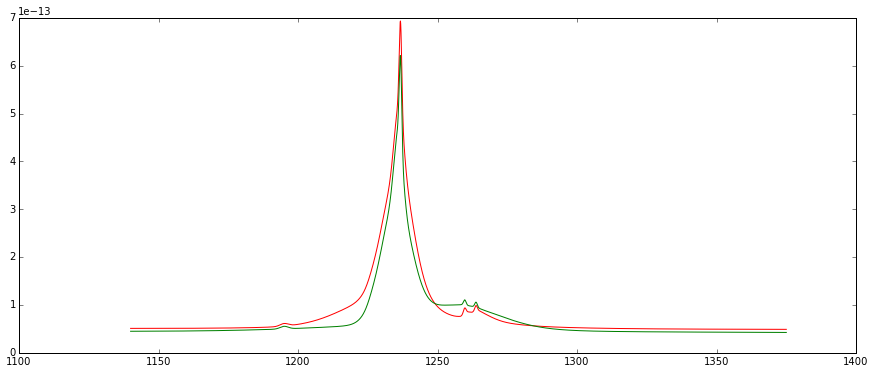

In [19]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')
fitted_spectrum = fit_result(spectrum.x.data)
plt.plot(spectrum.x.data, fitted_spectrum, 'g')

<h3>Input compound model overploted on spectrum</h3>

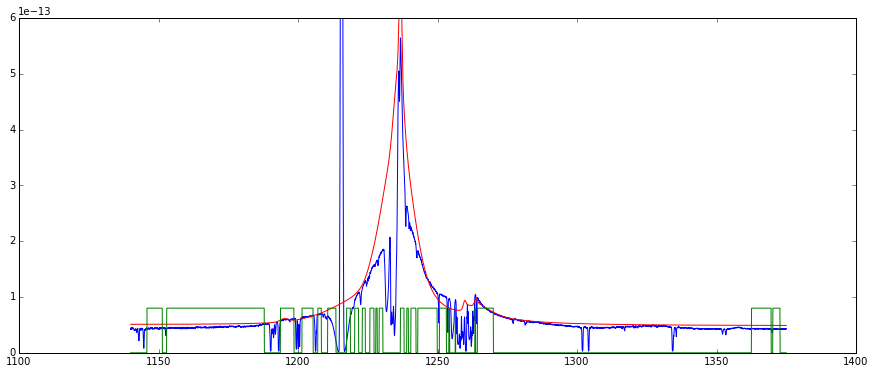

In [20]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')
plt.plot(spectrum.x.data, mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

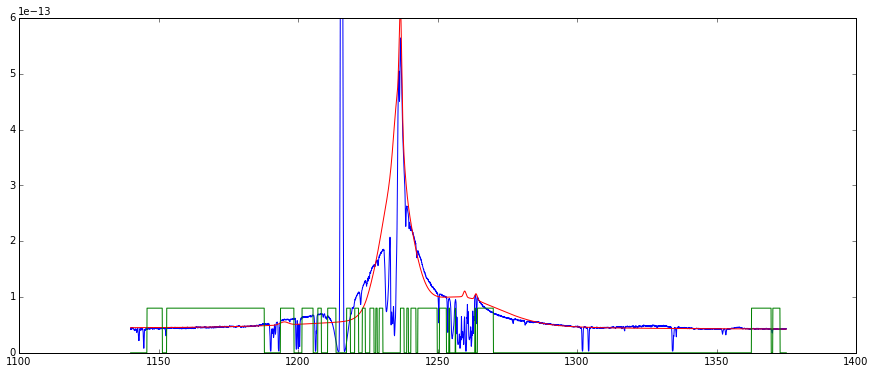

In [21]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, fitted_spectrum, 'r')
plt.plot(spectrum.x.data, mask*8.E-14, 'g')

<h3>Residuals</h3>

input spectrum - input model: plotted in yellow

input spectrum - fitted model: plotted in blue

In [22]:
residuals = spectrum.y.data - fitted_spectrum
original_residuals = spectrum.y.data - compound_model(spectrum.x.data)

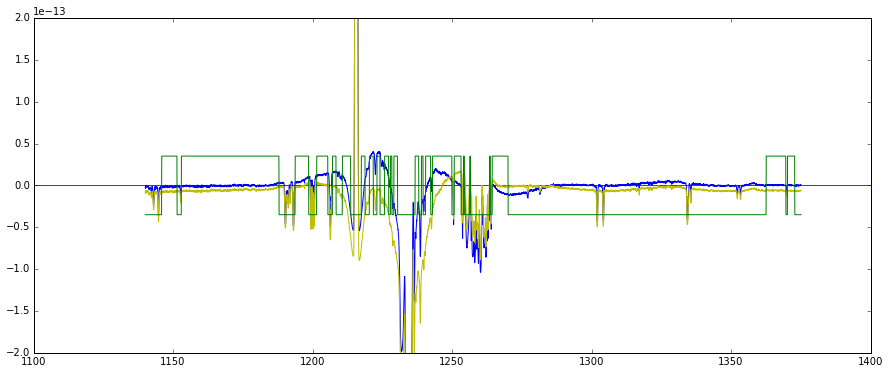

In [23]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(-2.e-13, 2.e-13)
plt.plot([1100., 1400], [0., 0.], 'r')
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, original_residuals, 'y')
plt.plot(spectrum.x.data, (mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

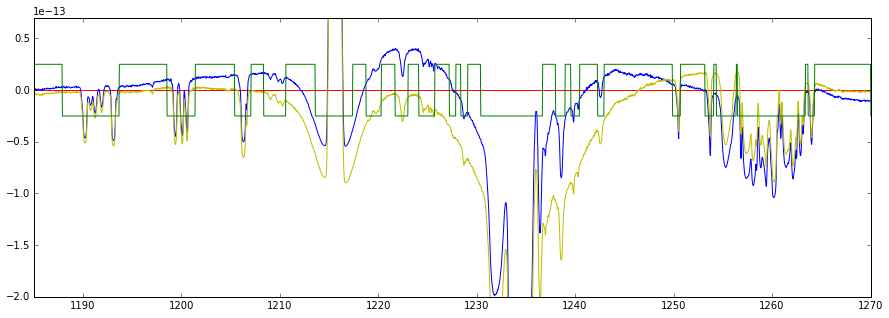

In [24]:
plt.gcf().set_size_inches(15.,5.)
plt.xlim(1185., 1270.)
plt.ylim(-2.e-13, 0.7e-13)
plt.plot([1185., 1270], [0., 0.], 'r')
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, original_residuals, 'y')
plt.plot(spectrum.x.data, (mask-0.5)*5.E-14, 'g')